In [48]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K 

import numpy as np
import os
import sys
from random import shuffle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.3.0


In [49]:
K.image_data_format()

'channels_last'

In [50]:
base = "C:/Users/bcohe/data/train/"

In [51]:
labels = {}
i = 0
for c in ['dogs', 'cats']:
    c_images = os.listdir(base+c)
    for image in c_images:
        labels[base+c+'/'+image] = i
    i += 1

In [52]:
def preprocess_image(img):
    w, h = 224, 224
    img = cv2.resize(img, (w,h))
    img = img/255.
    return img

In [53]:
def image_generator(input_ids, batch_size=32):
    while True:
        batch_paths = np.random.choice(a= input_ids, size = batch_size)
        batch_input = []
        batch_output = []

        for input_id in batch_paths:
            input = cv2.imread(input_id)
            output = labels[input_id]
            input = preprocess_image(input)

            batch_input += [input]
            batch_output += [output]

        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield (batch_x,	batch_y)

img_ids = list(labels.keys())
shuffle(img_ids)

In [54]:
# Split to training and validation sets
split = int(0.8*len(img_ids))
train_ids =img_ids[0:split]
valid_ids =img_ids[split:]

train_generator = image_generator(train_ids, batch_size = 32)
valid_generator = image_generator(valid_ids, batch_size = 32)

In [55]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(224,224,3), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(224,224,3), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(224,224,3), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [56]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [57]:
train_steps = len(train_ids) // 32
valid_steps = len(valid_ids) // 32
# Fit the model with training data and give prediction on validation set
model.fit_generator(train_generator,
                    validation_data=valid_generator,
                    epochs= 5, 
                    steps_per_epoch=train_steps, 
                    validation_steps=valid_steps)
# Save the model weights
model.save_weights('first_try.h5')

Epoch 1/5
70/70 [==============================] - 101s 1s/step - loss: 0.7058 - accuracy: 0.5223 - val_loss: 0.6882 - val_accuracy: 0.5184
Epoch 2/5
70/70 [==============================] - 100s 1s/step - loss: 0.6501 - accuracy: 0.6259 - val_loss: 0.6816 - val_accuracy: 0.5956
Epoch 3/5
70/70 [==============================] - 100s 1s/step - loss: 0.5781 - accuracy: 0.7058 - val_loss: 0.6668 - val_accuracy: 0.6489
Epoch 4/5
70/70 [==============================] - 100s 1s/step - loss: 0.4618 - accuracy: 0.7741 - val_loss: 0.6830 - val_accuracy: 0.6912
Epoch 5/5
70/70 [==============================] - 99s 1s/step - loss: 0.3723 - accuracy: 0.8424 - val_loss: 0.7122 - val_accuracy: 0.6838


In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 43264)            

In [59]:
def image_generator_test(input_ids, batch_size):
        batch_input = []
        batch_output = []

        for input_id in input_ids:
            input = cv2.imread(input_id)
            # give fake labels since we don't have labels of test images
            output = 0
            input = preprocess_image(input)
            batch_input += [input]
            batch_output += [output]

        batch_x = np.array(batch_input)
        # batch_y won't be used
        batch_y = np.array(batch_output)
        
        yield (batch_x, batch_y)

In [61]:
base = 'data/test/'

test_ids = list()
c_images = os.listdir(base)
for image in c_images:
    test_ids.append(base+'/'+image)

In [62]:
test_generator = image_generator_test(test_ids, batch_size = 10)
test_steps = len(test_ids) // 10

prob_pred = model.predict_generator(test_generator, steps = test_steps)
# transform predicted probability to 0 or 1 classes
cls_pred = (prob_pred > 0.5).astype(np.int)
# transform 0 or 1 classes to dogs or cats classes
cls_pred = ['dog' if x == 0 else 'cat' for x in cls_pred ]

Instructions for updating:
Please use Model.predict, which supports generators.


<ipython-input-62-55310cf5a836>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = (prob_pred > 0.5).astype(np.int)


In [63]:
def plot_images(test_ids, cls_pred):
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # load the images
        img = cv2.imread(test_ids[i])
        ax.imshow(img)

        # Show the classes as the label on the x-axis.
        xlabel = cls_pred[i]
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

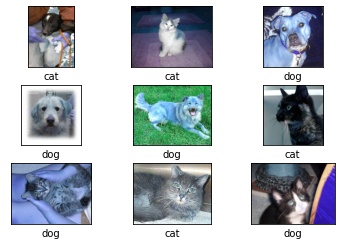

In [64]:
plot_images(test_ids,cls_pred)